# 版本说明v4 #
1. 使用LinearRegressor
2. 使用pipeline
3. 添加自定义的Transformer，可以选择指定的成分
4. 针对各个参数进行了调优
5. 封装了工具方法

# 拆分训练集和验证集 #

In [78]:
from hw1_utils import *
from sklearn.model_selection import train_test_split
%load_ext autoreload
%autoreload 2

X_train_full,y_train_full,X_test,test_option_index,test_options = load_data() # 加载训练和测试数据

X_train,X_valid,y_train,y_valid = train_test_split(X_train_full,
                                                   y_train_full,
                                                   test_size=0.2) # 分割验证集和验证集
n_features = X_train.shape[1]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 建立pipeline #

In [235]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

options = SelectTestOptionTransformer(test_option_index) # 选择测项特征的转化器
model = None
pipeline = Pipeline(steps=[('options',options),
                           ('scaler', StandardScaler()),
                           ('model' , model)])

search_utils = SearchUtils(pipeline,X_train_full,y_train_full)

## 使用LinearRegression模型 ##

In [236]:
from sklearn.model_selection import cross_val_score

pipeline.steps[2] = ('model',LinearRegression())

cross_val_score(pipeline,X_train_full,y_train_full).mean()

0.8443606921920231

# 剔除无关Feature #
1. 将所有feature放进去，计算cv_score，记录为best score
2. 然后分别减掉一个feature，选出最高的cv_score，如果，如果比best_score，那么去掉这个feature
3. 然后重复上面的操作，直到最高的score不再比best_score高为止。

In [237]:
pipeline.steps[2] = ('model',LinearRegression())
options.exclude = []

train_best_scores = []
valid_best_scores = []
exclude_params = []
best_score = 0
flag = True
while flag:
    param_range = [exclude_params + [test_options[i]] for i in range(18)]
    
    train_scores,valid_scores = validation_curve(pipeline,X_train_full,y_train_full,
                                                 'options__exclude',param_range)
    
    valid_score = valid_scores.mean(axis=1)              # 取验证集每个feature的平均分
    valid_max = valid_score.max()                        # 取出最高分
    valid_argmax = valid_score.argmax()                  # 最高分对应的feature值
    train_max = train_scores.mean(axis=1)[valid_argmax]  # 该feature在训练集的分数作为训练集最高分
    
    if valid_max > best_score:
        train_best_scores.append(train_max)
        valid_best_scores.append(valid_max)
        best_score = valid_max
        if len(valid_score) > 1:
            test_option_killed = test_options[valid_argmax]
            exclude_params.append(test_option_killed)
        print('剔除{}后，训练集得分为{:.4f}，验证集得分为{:.4f}'.format(
            test_option_killed,train_max,valid_max))
            
    else:
        print('剔除完成。')
        flag = False

剔除RH后，训练集得分为0.8826，验证集得分为0.8459
剔除THC后，训练集得分为0.8824，验证集得分为0.8466
剔除NMHC后，训练集得分为0.8822，验证集得分为0.8472
剔除AMB_TEMP后，训练集得分为0.8818，验证集得分为0.8479
剔除WIND_DIREC后，训练集得分为0.8815，验证集得分为0.8483
剔除NO2后，训练集得分为0.8812，验证集得分为0.8487
剔除WS_HR后，训练集得分为0.8810，验证集得分为0.8489
剔除WIND_SPEED后，训练集得分为0.8807，验证集得分为0.8492
剔除WD_HR后，训练集得分为0.8804，验证集得分为0.8494
剔除RAINFALL后，训练集得分为0.8801，验证集得分为0.8495
剔除CH4后，训练集得分为0.8795，验证集得分为0.8495
剔除完成。


In [167]:
exclude_params 

['RH',
 'THC',
 'NMHC',
 'AMB_TEMP',
 'WIND_DIREC',
 'NO2',
 'WS_HR',
 'WIND_SPEED',
 'WD_HR',
 'RAINFALL',
 'CH4']

In [170]:
valid_best_scores

[0.8458928052416193,
 0.8465658857667734,
 0.8472180038136082,
 0.8478696241065699,
 0.8483088469965182,
 0.8486776551720734,
 0.8489273441770215,
 0.8491832160605401,
 0.849413436958576,
 0.8494950728665771,
 0.8495024139932805]

In [175]:
train_best_scores

[0.8825598602446174,
 0.8823771158273139,
 0.8821632742422434,
 0.8818185465025833,
 0.8815265470784478,
 0.8811858669055083,
 0.880950170396131,
 0.8806664794354901,
 0.8804019823989597,
 0.8800917772013973,
 0.8795468026598325]

In [176]:
best_score

0.8495024139932805

## 噪音过滤后的学习曲线 ##

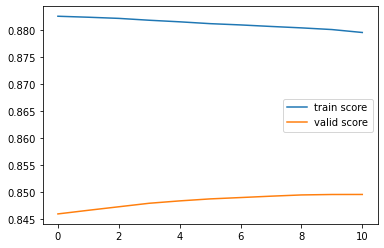

In [271]:
def plot_best_scores():
    x = len(train_best_scores)
    plt.plot(range(x),train_best_scores,label='train score')
    plt.plot(range(x),valid_best_scores,label='valid score')
    plt.legend()
    plt.show()
    
plot_best_scores()

# 删除低方差Feature #

## 保存之前获得的结果 ##

In [269]:
exclude_params = ['RH',
 'THC',
 'NMHC',
 'AMB_TEMP',
 'WIND_DIREC',
 'NO2',
 'WS_HR',
 'WIND_SPEED',
 'WD_HR',
 'RAINFALL',
 'CH4']

valid_best_scores = [0.8458928052416193,
 0.8465658857667734,
 0.8472180038136082,
 0.8478696241065699,
 0.8483088469965182,
 0.8486776551720734,
 0.8489273441770215,
 0.8491832160605401,
 0.849413436958576,
 0.8494950728665771,
 0.8495024139932805]

train_best_scores = [0.8825598602446174,
 0.8823771158273139,
 0.8821632742422434,
 0.8818185465025833,
 0.8815265470784478,
 0.8811858669055083,
 0.880950170396131,
 0.8806664794354901,
 0.8804019823989597,
 0.8800917772013973,
 0.8795468026598325]

best_score = 0.8495024139932805

## 配置pipeline ##

In [252]:
from sklearn.feature_selection import VarianceThreshold
if(len(pipeline.steps) == 3):
    pipeline.steps.insert(1,('variance',VarianceThreshold()))

options.exclude = exclude_params

pipeline.steps[3] = ('model',LinearRegression())
pipeline.steps

[('options',
  SelectTestOptionTransformer(exclude=['RH', 'THC', 'NMHC', 'AMB_TEMP',
                                       'WIND_DIREC', 'NO2', 'WS_HR', 'WIND_SPEED',
                                       'WD_HR', 'RAINFALL', 'CH4'],
                              exclude_index=None,
                              test_option_index={'AMB_TEMP': 0, 'CH4': 1, 'CO': 2,
                                                 'NMHC': 3, 'NO': 4, 'NO2': 5,
                                                 'NOx': 6, 'O3': 7, 'PM10': 8,
                                                 'PM2.5': 9, 'RAINFALL': 10,
                                                 'RH': 11, 'SO2': 12, 'THC': 13,
                                                 'WD_HR': 14, 'WIND_DIREC': 15,
                                                 'WIND_SPEED': 16, 'WS_HR': 17})),
 ('variance', VarianceThreshold(threshold=0.0)),
 ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('model',
  LinearRegression(co

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    6.6s finished


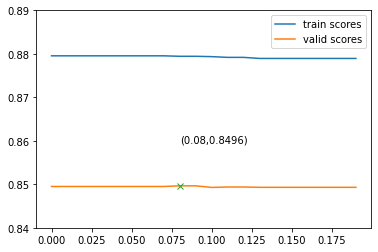

In [251]:
treshold_range = [0.01 * i for i in range(20)]

history = search_utils.search('variance__threshold',treshold_range,ylim=(.84,.89))

## 方差过滤后的学习曲线##

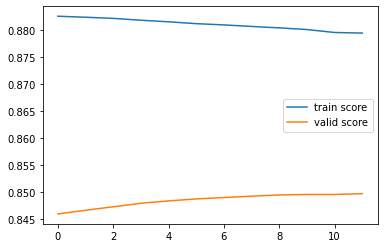

In [272]:
valid_scores = history[3].mean(axis=1)
valid_max = valid_scores.max()
valid_argmax = valid_scores.argmax()
train_max = history[2][valid_argmax].mean()
if len(valid_best_scores)==11:
    valid_best_scores.append(valid_max)
    train_best_scores.append(train_max)
plot_best_scores()

In [253]:
pipeline.steps[1][1].threshold = 0.08
pipeline.steps

[('options',
  SelectTestOptionTransformer(exclude=['RH', 'THC', 'NMHC', 'AMB_TEMP',
                                       'WIND_DIREC', 'NO2', 'WS_HR', 'WIND_SPEED',
                                       'WD_HR', 'RAINFALL', 'CH4'],
                              exclude_index=None,
                              test_option_index={'AMB_TEMP': 0, 'CH4': 1, 'CO': 2,
                                                 'NMHC': 3, 'NO': 4, 'NO2': 5,
                                                 'NOx': 6, 'O3': 7, 'PM10': 8,
                                                 'PM2.5': 9, 'RAINFALL': 10,
                                                 'RH': 11, 'SO2': 12, 'THC': 13,
                                                 'WD_HR': 14, 'WIND_DIREC': 15,
                                                 'WIND_SPEED': 16, 'WS_HR': 17})),
 ('variance', VarianceThreshold(threshold=0.08)),
 ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('model',
  LinearRegression(c

# 输出数据 #

In [255]:
pipeline.fit(X_train_full,y_train_full)

preds_train_full = pipeline.predict(X_train_full)
print('训练集的RMSE:{:.5f}'.format(mean_squared_error(preds_train_full,y_train_full)**0.5))

preds_test = pipeline.predict(X_test)
ids = ['id_' + str(i) for i in range(len(X_test))]
output = pd.DataFrame({'id':ids,
                       'value':preds_test})
output.to_csv('output/pm25_submission.csv',index=False)

训练集的RMSE:5.75118
